In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

In [3]:
import pickle
from itertools import chain
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [4]:
import textgen

## Load data

In [5]:
comments_path = textgen.get_resource_path("toxicity-data-merged-comments-05251530.csv")
comments = pd.read_csv(comments_path, index_col=0)
posts_path = textgen.get_resource_path("toxicity-data-merged-posts-05251530.csv")
posts = pd.read_csv(posts_path, index_col=0)

In [6]:
def load_pretrained_wv(fpath):
    with open(fpath, "rb") as fin:
        (itos, stoi, vectors) = pickle.load(fin)
        src_vocab = textgen.Vocabulary(itos, stoi, vectors)
    return src_vocab
posts_vocab = load_pretrained_wv(textgen.get_resource_path("word_vectors.pkl"))

In [7]:
chunks = [x for x in chain.from_iterable([x.split("\\") for x in comments.CommentContent.tolist()])]

In [8]:
comments_vocab = textgen.Vocabulary()
comments_vocab.build_vocabulary(chunks)

In [9]:
vocab_path = textgen.get_data_path("vocab.pkl")
with open(vocab_path, "wb") as fout:
    pickle.dump((posts_vocab, comments_vocab), fout)
posts_vocab, comments_vocab

(<Vocabulary: 27074 items, emb dim: (27074, 300)>, <Vocabulary: 1468 items>)

In [10]:
toxic_data = textgen.ToxicDataset(posts, comments, posts_vocab, comments_vocab)
toxic_data_path = textgen.get_data_path("toxic_data.pkl")
toxic_data.save(toxic_data_path)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\seantyh\AppData\Local\Temp\jieba.cache
Loading model cost 0.683 seconds.
Prefix dict has been built succesfully.


Cannot find gayo01
Cannot find gayo01
Cannot find gayo01


In [11]:
toxic_data_path = textgen.get_data_path("toxic_data.pkl")
toxic_data = textgen.ToxicDataset.load(toxic_data_path)
toxic_data

<ToxicDataset: 240 samples>

## Batching Data

In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [13]:
from torch.utils.data import DataLoader
from functools import partial
collate_fn = partial(textgen.collate_fn, 
                     src_pad=posts_vocab.stoi["<PAD>"], 
                     tgt_pad=comments_vocab.stoi["<PAD>"])

In [14]:
xx, yy = next(iter(DataLoader(toxic_data, batch_size=2, collate_fn=collate_fn)))

In [15]:
cpumodel = textgen.ToxicCommentModel(posts_vocab, comments_vocab, torch.device('cpu'))
cpumodel(xx, yy)

tensor([[[-7.1750, -7.4919, -6.9320,  ..., -7.2724, -7.2559, -7.2487],
         [-7.2659, -7.4271, -6.8783,  ..., -7.2567, -7.3322, -7.1845],
         [-7.4044, -7.3077, -6.9152,  ..., -7.3320, -7.5062, -7.1983],
         ...,
         [-7.3432, -7.1550, -7.2504,  ..., -7.2388, -7.2481, -7.1735],
         [-7.3352, -7.1606, -7.2762,  ..., -7.2406, -7.2485, -7.1646],
         [-7.3300, -7.1664, -7.2868,  ..., -7.2412, -7.2494, -7.1560]],

        [[-7.1701, -7.4987, -6.9634,  ..., -7.2775, -7.2392, -7.2492],
         [-7.0333, -7.1475, -6.9664,  ..., -7.1346, -7.4502, -7.4341],
         [-7.2212, -7.0565, -7.0203,  ..., -7.2636, -7.3988, -7.2632],
         ...,
         [-7.1985, -7.4982, -6.9183,  ..., -7.3690, -7.1566, -7.3234],
         [-7.3523, -7.1444, -6.9164,  ..., -7.3388, -7.2525, -7.0813],
         [-7.2846, -7.0613, -7.0112,  ..., -7.3121, -7.2251, -7.2206]]],
       grad_fn=<CopySlices>)

In [16]:
USE_CUDA = True
if torch.cuda.is_available() and USE_CUDA:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [17]:
import visdom
vis = visdom.Visdom()

In [18]:
vis.close()
loss_fn = nn.NLLLoss()
model = textgen.ToxicCommentModel(posts_vocab, comments_vocab, device)
model = model.to(device)
adam = optim.Adam(model.parameters(), lr=1e-2)
total_epoch = 0
loss_vec = []
acc_vec = []

In [19]:
def display_activation(module, input, output):      
    vis.bar(output[0], win='activation', opts=dict(title='activation'))
if 'hook' in locals():
    hook.remove()
hook = model.fc2.register_forward_hook(display_activation)

In [20]:
from itertools import islice
n_epoch = 50
model.train()
fc1_params = []
for epoch_i in tqdm(range(n_epoch)):
    acc_epoch = []
    loss_epoch = []
    loader = DataLoader(toxic_data, batch_size=30, 
                        collate_fn=collate_fn)
    for src_batch, tgt_batch in loader:      
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        out = model(src_batch, tgt_batch)
        
        loss = None
        for batch_i in range(out.shape[0]):
            out_batch_x = out[batch_i, :, :]
            tgt_batch_x = tgt_batch[batch_i, :]            
            
            out_batch_x = out_batch_x[tgt_batch_x != 1466]
            tgt_batch_x = tgt_batch_x[tgt_batch_x != 1466]                        
            loss_val = loss_fn(out_batch_x, tgt_batch_x)
            
            if loss:
                loss += loss_val
            else:
                loss = loss_val
        loss_epoch.append(loss.item())
        
        out_seq = out.argmax(2).detach().cpu().numpy()
        tgt_seq = tgt_batch.detach().cpu().numpy()
        acc_seq = [textgen.get_seq_overlap(out_seq[i], tgt_seq[i], comments_vocab) 
                   for i in range(len(tgt_seq))]
        acc = np.mean(acc_seq)
        acc_epoch.append(acc)
        
        # diagnosis
        fc1_params = list(model.fc1.parameters())[0].cpu().detach().numpy()
        
        adam.zero_grad()
        loss.backward()
        adam.step()
        
    total_epoch += 1        
    vis.line(X=[total_epoch], Y=[np.sum(loss_epoch)], win='lossline', update='append', opts=dict(title='loss'))
    loss_vec.append(np.sum(loss_epoch))
    acc_vec.append(np.mean(acc_epoch))
    

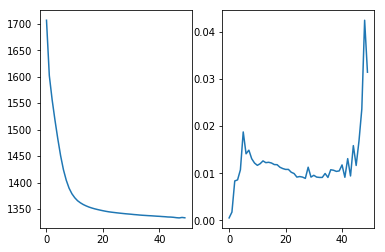

In [21]:
fig, axes = plt.subplots(1,2)
axes[0].plot(loss_vec)
axes[1].plot(acc_vec)

In [35]:
yy

tensor([[ 170,  171,  172,  173, 1465, 1466, 1466, 1466, 1466, 1466, 1466],
        [ 464,  465,  466,  467,  468,  469,  470,  471,  472,  473, 1465]])

In [22]:
intext = """
郭樹清在發言稿中強調，貿易戰不能解決任何問題，損人不利己且危害全世界。
從中國來看，美國固然可以把關稅加到極限水平，但是這對中國經濟的影響將非常有限。
國際上有觀點認為，中國經濟的快速發展是實行「國家壟斷資本主義」的結果，這種說法毫無根據。"""

model.eval()
# textgen.predict(model, intext, posts_vocab, comments_vocab, device)
out = model(xx.to(device))
# out = model(xx.to(device), yy.to(device))
ypred = out.argmax(2).cpu().numpy().tolist()[0]
textgen.inverse_convert_comment(ypred, comments_vocab)

['蔡英文',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>',
 '<EOS>']

In [82]:
topv, topi = out.topk(10)
topv = topv[0].cpu().detach().numpy()
topi = topi[0].cpu().detach().numpy()

visited = set()
rs = np.random.RandomState(343)
for step_i in range(topv.shape[1]):
    logits = topv[step_i]
    tok_idx = topi[step_i]
        
    for vec_idx, tok_logit in enumerate(logits):        
        tok_i = tok_idx[vec_idx]
        if tok_i in visited or tok_i >= comments_vocab.stoi["<SOS>"]:
            logits[vec_idx] *= 10
    probs = np.exp(logits)/np.sum(np.exp(logits))
    selected_idx = np.argwhere(np.random.multinomial(1, probs)).flatten()[0]
    selected = tok_idx[selected_idx]    
    visited.add(selected)    
    if rs.binomial(1, step_i * 0.1):
        break
    print(comments_vocab.to_texts([selected]))

['你做那麼爛']
['何止與惡零距離，']
['的']
['認為']
['又扮起耶穌了？']


In [69]:
comments_vocab.stoi["<SOS>"]

1464

In [83]:
model_path = textgen.get_data_path("toxic-model-max-40-100-0527.pt")

torch.save(model.state_dict(), model_path)

In [52]:
visited

{0, 1, 3, 4, 6, 8}